In [1]:
! jt -t grade3 -nf opensans

/bin/sh: jt: command not found


<h1><center>1. Load Data</center></h1>



In [2]:
import os
import warnings
import pandas as pd

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from synthesized.testing.evaluation import Evaluation
evaluation = Evaluation(config_path='configs/evaluation/dataset_evaluation.json', name='james') # use this line if you want to run this notbook manually
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


In [4]:
data = pd.read_csv(evaluation.config['data'])
data = data.drop(evaluation.config['ignore_columns'], axis=1)
data.dropna(inplace=True)
data.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,effort,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,"(0.00649, 0.04]",9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,"(0.000309, 0.00134]",2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,"(0.000309, 0.00134]",3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,"(0.000309, 0.00134]",3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,"(-0.001, 0.000309]",63588.0,7,0,1,0,0.0






<h1><center>2. Train model and generate synthetic data</center></h1>

In [5]:
from sklearn.model_selection import train_test_split
import synthesized

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [7]:
def train_and_synthesize(synthesizer_class=evaluation.config["synthesizer_class"]):
    assert synthesizer_class in {"BasicSynthesizer", "SeriesSynthesizer"}
    synthesizer_constructor = getattr(synthesized, synthesizer_class)
    loss_history = list()
    
    def callback(synth, iteration, losses):
        if len(loss_history) == 0:
            loss_history.append(losses)
        else:
            loss_history.append({name: losses[name] for name in loss_history[0]})
    
    with synthesizer_constructor(df=data, **evaluation.config['params']) as synthesizer:
        synthesizer.learn(
            df_train=train, num_iterations=evaluation.config['num_iterations'],
            callback=callback, callback_freq=100
        )
        if synthesizer_class == "BasicSynthesizer":
            synthesized_data = synthesizer.synthesize(num_rows=len(test))
        else:
            series_lengths = data.groupby(evaluation.config["params"]["identifier_label"]).count().to_numpy().transpose()
            series_lengths = list(series_lengths[0])
            synthesized_data = synthesizer.synthesize(series_lengths=series_lengths)
        return synthesizer, synthesized_data, loss_history

In [8]:
%%capture
synthesizers_and_results = [train_and_synthesize() for i in range(evaluation.config['num_passes'])]
synthesizer = synthesizers_and_results[0][0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Plot losses

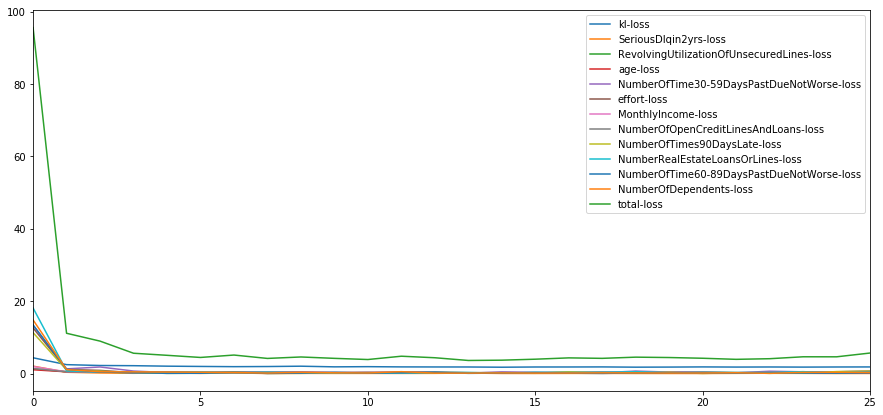

In [9]:
loss_history = synthesizers_and_results[0][2]
pd.DataFrame.from_records(loss_history).plot(figsize=(15,7))

## Display aggregated statistics 

In [10]:
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns

In [11]:
def plot_avg_distances():
    result = []
    for i, (synthesizer, synthesized_, _) in enumerate(synthesizers_and_results):
        test_ = synthesizer.preprocess(test)
        synthesized_ = synthesizer.preprocess(synthesized_)
        distances = [ks_2samp(test_[col], synthesized_[col])[0] for col in synthesized_.columns]
        avg_distance = np.mean(distances)
        print('run: {}, AVG distance: {}'.format(i+1, avg_distance))
        result.append({'run': i+1, 'avg_distance': avg_distance})
        evaluation['avg_distance'] = avg_distance
    df = pd.DataFrame.from_records(result)
    df['run'] = df['run'].astype('category')
    g = sns.barplot(y='run', x='avg_distance', data=df)
    g.set_xlim(0.0, 1.0)

run: 1, AVG distance: 0.03502643116268364


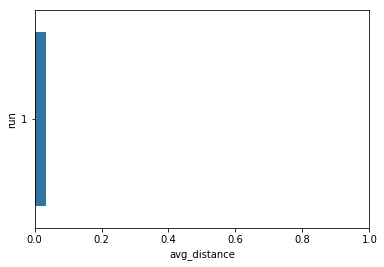

In [12]:
plot_avg_distances()

## Details for the 1st Run 

In [13]:
from synthesized.testing import UtilityTesting
testing = UtilityTesting(synthesizer, train, test, synthesizers_and_results[0][1])

Average distance: 0.034845839285849264


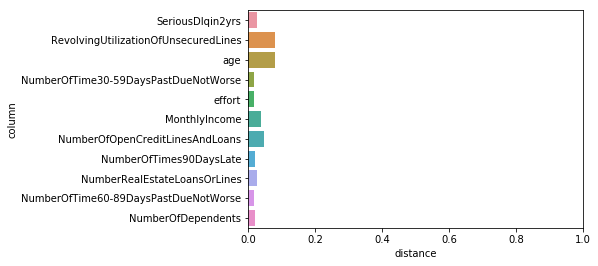

In [14]:
testing.show_distribution_distances()

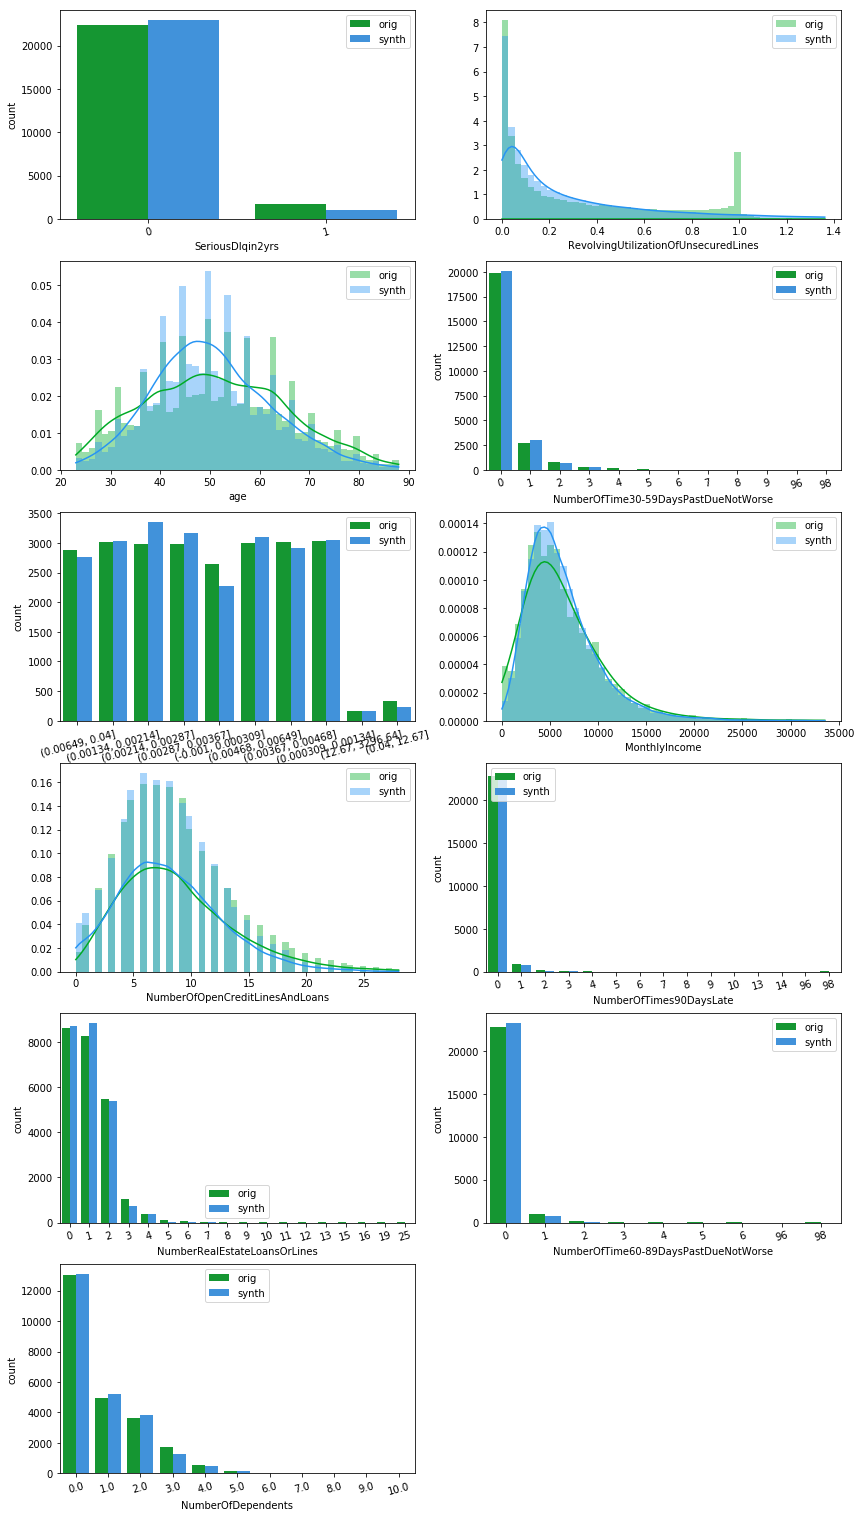

In [15]:
testing.show_distributions(remove_outliers=0.01)

## Display correlations

Average diff: -0.03704852295598721


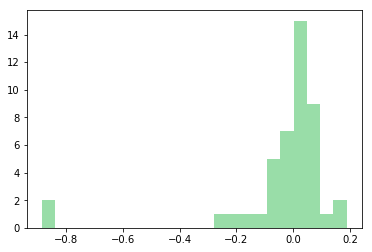

In [16]:
testing.show_correlation_diffs(threshold=0.2)

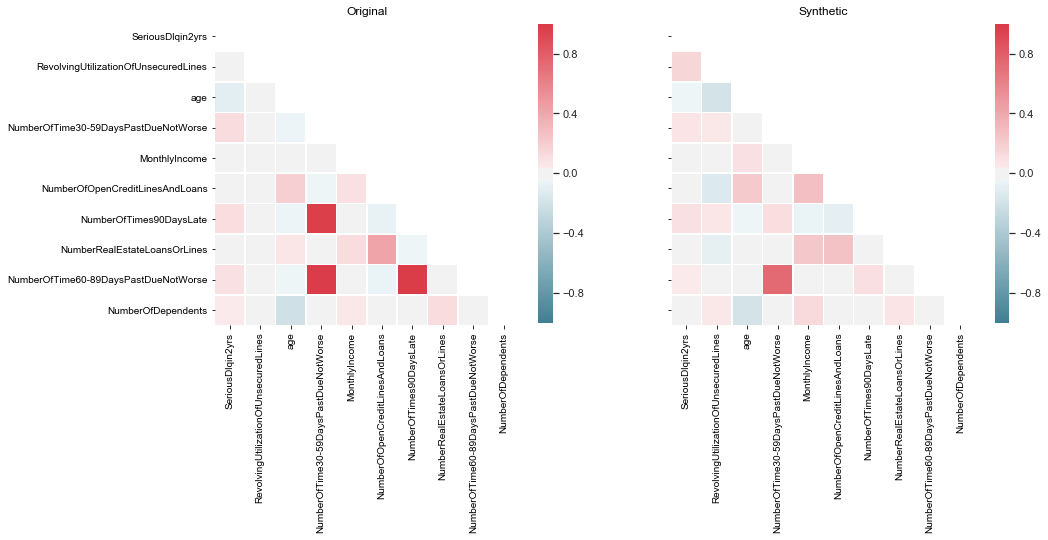

In [17]:
testing.show_corr_matrices()

## Demonstrate the utility for training ML models

In [18]:
try:
    evaluation['utility'] = testing.utility(target=evaluation.config['target'])
except:
    evaluation['utility'] = 0.0

ROC AUC (orig): 0.85644078760145
ROC AUC (synth): 0.802610832982183


In [19]:
print(evaluation.metrics)

OrderedDict([('avg_distance', [0.03502643116268364]), ('utility', [0.802610832982183])])
